<a href="https://colab.research.google.com/github/azizeko29/new_deteksi_fraud/blob/master/%5Bnew_ROS%5D_PAYSIM_pemodelan_ensemble_learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import collections
import time
from scipy import stats

In [0]:
# %matplotlib inline
# from IPython.display import display
# from sklearn import metrics
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from statistics import stdev

from sklearn import tree

from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [0]:
np.random.seed(1)

In [0]:
def confussion_matrik(actual,predict):
    TP,FP,FN,TN = 0,0,0,0
    for i,val in enumerate(actual):
        if val == 0:
            if val == predict[i]:
                TN += 1
            else:
                FP += 1
        if val == 1:
            if val == predict[i]:
                TP += 1
            else:
                FN += 1
    return TP,FP,FN,TN
 
def acc_sens_spec(actual,predict):
    TP,FP,FN,TN = confussion_matrik(actual,predict)
# akurasi
    if (TP+FP+FN+TN) == 0 :
        accuracy = 0 
    else :
        accuracy = (TP+TN)/(TP+FP+FN+TN)
        
# sensitivity
    if (TP+FN) == 0 :
        sensitivity = 0
    else :
        sensitivity = TP/(TP+FN)
        
# specifity    
    if (TN +FP) == 0 :
        specifity = 0
    else :
        specifity = TN/(TN +FP)
        
# precision
    if (TP+FP) == 0 :
        precision = 0
    else :
        precision = TP/(TP+FP)

# recall
    recall = sensitivity

# f1_score
    if (precision+recall) == 0 :
        f1_score = 0
    else :
        f1_score = 2*((precision*recall)/(precision+recall))  
    
    return accuracy,sensitivity,specifity,precision,recall,f1_score

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    #how many correct predictions?
    correct = 0
    #for each actual label
    for i in range(len(actual)):
        #if actual matches predicted label
        if actual[i] == predicted[i]:
            #add 1 to the correct iterator
            correct += 1
    #return percentage of predictions that were correct
    return correct / float(len(actual)) * 100.0

In [0]:
# confussion_matrik(y,pred)

In [0]:
# accuracy,sensitivity,specifity = acc_sens_spec(y,pred)
# print('acc',accuracy)
# print('sens',sensitivity)
# print('spec',specifity)

In [0]:
# accuracy_metric(y,RF.predict(X))

In [0]:
def cross_val_split(X,fold=2,seed=0):
    np.random.seed(seed)
    n_folds= fold
    size = X.shape[0]/n_folds
    X_idx = list(range(X.shape[0]))
    folds_data= []
    for i in range(n_folds):
#         print(X_idx)
        random_idx = list(np.random.choice(X_idx,int(size),replace=False))
#         print(random_idx)
        X_idx = [idx for idx in X_idx if idx not in random_idx]
#         print(X_idx)

        folds_data.append(random_idx)
#         print("--")
    return folds_data

def kfold_cross_validation(model,X,y, n_fold=2, n_seed=0):
    folds = cross_val_split(X,fold=n_fold,seed=n_seed)
    fold_result =[]
    for i in range(len(folds)):
    #     print(i)
        train = []
        for j in range(len(folds)):
            if j != i:
                train = train + folds[j]
        test = folds[i]

        X_train = X.iloc[train,:].reset_index(drop=True)
        y_train = y[train].reset_index(drop=True)

        X_test = X.iloc[test,:].reset_index(drop=True)
        y_test = y[test].reset_index(drop=True)


        t0 = time.time()
        model.fit(X_train, y_train)
        t1 = time.time()
        waktu = t1 - t0

        predict = model.predict(X_test)
        accuracy,sensitivity,specifity,precision,recall,f1_score = acc_sens_spec(y_test,predict)

        result = [accuracy,sensitivity,specifity,precision,recall,f1_score,waktu]
        fold_result.append(result)
        
    return fold_result

In [0]:
def testing(model,X_test,y_test):
    result_ = []

#       t0 = time.time()
#       model.fit(X_train, y_train)
#       t1 = time.time()
#       waktu = t1 - t0
    predict = model.predict(X_test)
    accuracy,sensitivity,specifity,precision,recall,f1_score = acc_sens_spec(y_test,predict)

    result = [accuracy,sensitivity,specifity,precision,recall,f1_score]
        
    result_.append(result)
        
    return result_

In [0]:
# from sklearn.decomposition import PCA
# import pylab as pl
# def plot_this(X_rs,y_rs,method):
#   # Use principal component to condense the 10 features to 2 features
#   pca = PCA(n_components=2).fit(X_rs)
#   pca_2d = pca.transform(X_rs)
#   # Assign colors
#   for i in range(0, pca_2d.shape[0]):
#     if y_rs[i] == 0:
#       c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='o')
#     elif y_rs[i] == 1:
#       c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='*')  
#   pl.legend([c1, c2], ['Class 1', 'Class 2'])
#   pl.title(method)
#   pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
#   pl.show()
    


## ---------

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1wdm61XLjzHJTfIKjRMoZfheww2HLAR0I' # The shareable link

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('paysim.csv')  
read_df = pd.read_csv('paysim.csv')
# Dataset is now stored in a Pandas Dataframe
# df.info()


     |████████████████████████████████| 993kB 9.5MB/s 
1wdm61XLjzHJTfIKjRMoZfheww2HLAR0I


In [0]:
df = read_df.copy()
df['Class'] = read_df['isFraud']
df = df.drop(['isFraud'], axis=1)

In [0]:
df.shape

(6362620, 11)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFlaggedFraud    int64
Class             int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [0]:
df['Class'].value_counts()

0    6354407
1       8213
Name: Class, dtype: int64

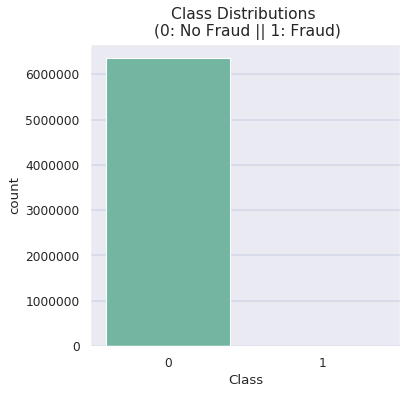

In [0]:
plt.figure(1,figsize=(5, 5), dpi=80)
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
sns.countplot('Class', data=df,palette='Set2')


In [0]:
count = 0
for a in df.columns:
    if df[a].isnull().sum() > 0 :
        print(a)
        count+=1
count

0

In [0]:
len(df.columns)

11

In [0]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,Class
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [0]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig',
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [0]:
df.isnull().values.any()

False

----------------------------------

2.1. Which types of transactions are fraudulent?
We find that of the five types of transactions, fraud occurs only in two of them (see also kernels by Net, Philipp Schmidt and Ibe_Noriaki): 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs (see the right half of the plot in section 5.1). These observations appear, at first, to bear out the description provided on Kaggle for the modus operandi of fraudulent transactions in this dataset, namely, fraud is committed by first transferring out funds to another account which subsequently cashes it out. We will return to this issue later in section 2.4

In [0]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.Class == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.Class == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.Class == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [0]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [0]:
df['Class'].value_counts()

0    6354407
1       8213
Name: Class, dtype: int64

From the exploratory data analysis (EDA) of section 2, we know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X for analysis

In [0]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['Class']
del X['Class']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).

In [0]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


Since the destination account balances being zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. Doing so would mask this indicator of fraud and make fraudulent transactions appear genuine. Instead, below we replace the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.

In [0]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

In [0]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = -1

In [0]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

In [0]:
df = X.copy()
df['Class'] = Y.copy()

In [0]:
df['Class'].value_counts()

0    2762196
1       8213
Name: Class, dtype: int64

In [0]:
df.columns

Index(['step', 'type', 'amount', 'oldBalanceOrig', 'newBalanceOrig',
       'oldBalanceDest', 'newBalanceDest', 'errorBalanceOrig',
       'errorBalanceDest', 'Class'],
      dtype='object')

In [0]:
# df_ = df.copy()

In [0]:
# df['type'].unique()

In [0]:
# a = {}
# i = 1
# for m in df_['type'].unique():
#   if m not in a :
#     a[m] = i
#     i +=1
    
# df_['type'] = df_['type'].map(a)
# # a

In [0]:
# a = {}
# i = 1
# for m in df_['nameOrig'].unique():
#   if m not in a :
#     a[m] = i
#     i +=1
    
# df_['nameOrig'] = df_['nameOrig'].map(a)

In [0]:
# a = {}
# i = 1
# for m in df_['nameDest'].unique():
#   if m not in a :
#     a[m] = i
#     i +=1
    
# df_['nameDest'] = df_['nameDest'].map(a)

In [0]:
# df_.tail()

In [0]:
df['Class'].value_counts()

0    2762196
1       8213
Name: Class, dtype: int64

In [0]:
X = df.drop('Class', axis=1)
y = df['Class'].copy()

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [0]:
y_train.shape

(1939286,)

In [0]:
y_test.shape

(831123,)

In [0]:
y_test.value_counts()

0    828659
1      2464
Name: Class, dtype: int64

In [0]:
y_train.value_counts()

0    1933537
1       5749
Name: Class, dtype: int64

In [0]:
df_train = X_train.copy()
df_train['Class'] = y_train.copy()

In [0]:
# # Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# # RobustScaler is less prone to outliers.

# std_scaler = StandardScaler()
# rob_scaler = RobustScaler()
# minmax_scaler = MinMaxScaler()

# # df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
# # df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# df['scaled_amount'] = minmax_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
# df['scaled_time'] = minmax_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# df.drop(['Time','Amount'], axis=1, inplace=True)

# scaled_amount = df['scaled_amount']
# scaled_time = df['scaled_time']

# df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
# df.insert(0, 'scaled_amount', scaled_amount)
# df.insert(1, 'scaled_time', scaled_time)

# # Amount and Time are Scaled!

# df.head()

In [0]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples
df_copy = df_train.copy()
# df_copy = df_copy.sample(frac=1)

fraud_df = df_copy.loc[df_copy['Class'] == 1]
non_fraud_df = df_copy.loc[df_copy['Class'] == 0].sample(n=5749,random_state=1)

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
df_new = normal_distributed_df.sample(frac=1, random_state=1)
df_new = df_new.reset_index()
df_new = df_new.drop('index', axis=1)
df_new.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest,Class
0,636,0,654250.76,654250.76,0.00,-1.00,-1.00,0.00,654250.76,1
1,359,1,48819.52,159544.07,110724.55,64198.29,113017.81,0.00,0.00,0
2,187,1,57015.55,-1.00,-1.00,1068141.00,1125156.55,57015.55,0.00,0
3,83,0,24412.07,24412.07,0.00,-1.00,-1.00,0.00,24412.07,1
4,228,0,382887.59,10903.00,0.00,1295694.78,2108598.16,371984.59,-430015.79,0


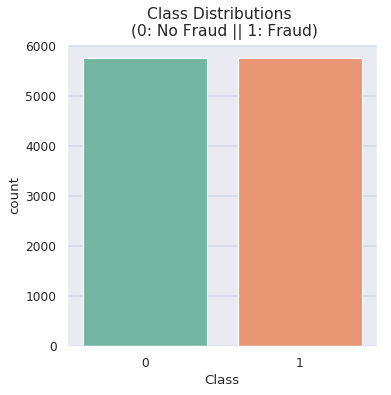

In [0]:
plt.figure(1,figsize=(5, 5), dpi=80)
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
sns.countplot('Class', data=df_new,palette='Set2')

In [0]:
# X = df.drop('Class', axis=1)
# y = df['Class'].copy()

In [0]:
X_new = df_new.drop('Class', axis=1)
y_new = df_new['Class'].copy()

In [0]:
# y_new.value_counts()

In [0]:
X_new.tail()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
11493,690,1,194484.97,-1.00,-1.0,2047918.06,2242403.04,194484.97,-0.01
11494,325,1,319346.26,1401.00,0.0,190016.01,509362.27,317945.26,0.00
11495,444,0,10000000.00,23752520.60,13752520.6,-1.00,-1.00,0.00,10000000.00
11496,444,1,10000000.00,10000000.00,0.0,185609.51,10185609.51,0.00,0.00
11497,262,0,2016790.84,2016790.84,0.0,-1.00,-1.00,0.00,2016790.84


In [0]:

# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# # RobustScaler is less prone to outliers.

# std_scaler = StandardScaler()
# rob_scaler = RobustScaler()
# minmax_scaler = MinMaxScaler()

# X_neww = minmax_scaler.fit_transform(X_new)
# X_new = pd.DataFrame(X_neww, columns=X_new.columns)
# X_new.tail()

# # k-folds


In [0]:
def validasi_model (clf,X,y,kfolds):
    CV_SKLearn = kfold_cross_validation(clf,X,y,n_fold=kfolds,n_seed=1)
    df_result = pd.DataFrame(data= CV_SKLearn, columns=['Akurasi','Sensitivity','Specifity','precision','recall','f1_score','Waktu'])

    df_result.insert(loc=0, column='No', value=list(range(1,df_result.shape[0]+1)))
    df_result = df_result.set_index('No')

    del df_result.index.name

    df_result = df_result.append(df_result.describe()[1:2])
    
    return df_result
# result_SKLearn = result_SKLearn.append('')

In [0]:
# Classifier Libraries
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

    
clf_RF = RandomForestClassifier(random_state=1,n_estimators=100)
clf_AB = AdaBoostClassifier(random_state=1,n_estimators=100)
clf_B = BaggingClassifier(random_state=1,n_estimators=100)
clf_ET = ExtraTreesClassifier(random_state=1,n_estimators=100)
clf_GB = GradientBoostingClassifier(random_state=1,n_estimators=50)

##skenario 
skenario_1 = {}
skenario_1['1'] = clf_RF
# skenario_1['2'] = clf_AB
# skenario_1['3'] = clf_B
# skenario_1['4'] = clf_ET
skenario_1['5'] = clf_GB

In [0]:
result = {}
for i in skenario_1:
  
    clf_skenario = skenario_1[i]
    result[i] = validasi_model(clf_skenario,X_new,y_new,5)
                

df_result = pd.DataFrame()
for i in skenario_1:
    df_result = df_result.append(result[i].iloc[5:,:])
    
df_result.insert(loc=0, column='No', value=list(range(df_result.shape[0])))
df_result = df_result.set_index('No')

del df_result.index.name

df_result

,Akurasi,Sensitivity,Specifity,precision,recall,f1_score,Waktu
0,0.998173,0.997368,0.998949,0.998962,0.997368,0.998163,0.788578
1,0.997651,0.995791,0.999466,0.999489,0.995791,0.997635,0.269985


In [0]:
# importances = clf.feature_importances_
# indices = np.argsort(importances)[::-1]
# fitur_importance =[]
# for f in range(X_new.shape[1]):
#     if  importances[indices[f]] > 0 :
#         fitur_importance.append([X_new.columns[indices[f]],importances[indices[f]]])
#         print("%2d) %-*s %f" % (f + 1, 30,
#         X_new.columns[indices[f]],
#         importances[indices[f]]))

In [0]:
# df_FI = pd.DataFrame(data=fitur_importance,columns=['fitur','value'])
# # np.array(df_FI['fitur'])
# df_FI

In [0]:
# dot_data = StringIO()  
# tree.export_graphviz(clf.estimators_[8], out_file=dot_data,  
#                          feature_names=X_new.columns)  
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [0]:
# dot_data = StringIO()  
# tree.export_graphviz(clf_DT,out_file=dot_data,feature_names=X_new.columns)  
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

----

## Testing


In [0]:
def validasi_testing (clf,X,y):
    testing_result = testing(clf,X,y)
    df_result = pd.DataFrame(data= testing_result, columns=['Akurasi','Sensitivity','Specifity','precision','recall','f1_score'])

    df_result.insert(loc=0, column='No', value=list(range(1,df_result.shape[0]+1)))
    df_result = df_result.set_index('No')

    del df_result.index.name

#     df_result = df_result.append(df_result.describe()[1:2])
    
    return df_result
# result_SKLearn = result_SKLearn.append('')

In [0]:
from sklearn.ensemble import RandomForestClassifier
n_tree = 100
# clf_RF_ = RandomForestClassifier(random_state=1,n_estimators=n_tree, max_features='sqrt')
clf_RF.fit(X_new,y_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
n_tree = 100
# clf = RandomForestClassifier(random_state=1,n_estimators=n_tree, max_features='sqrt')
clf_GB = GradientBoostingClassifier(random_state=1,n_estimators=50)

clf_GB.fit(X_new,y_new)



GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
result = {}
for i in skenario_1:
  
    clf_skenario = skenario_1[i]
    result[i] = validasi_testing(clf_skenario,X_test,y_test)
    
                
df_result = pd.DataFrame()
for i in skenario_1:
    df_result = df_result.append(result[i])
    
df_result.insert(loc=0, column='No', value=list(range(df_result.shape[0])))
df_result = df_result.set_index('No')

del df_result.index.name

df_result

,Akurasi,Sensitivity,Specifity,precision,recall,f1_score
0,0.999498,0.997565,0.999504,0.856745,0.997565,0.921808
1,0.999764,0.997565,0.999771,0.928248,0.997565,0.961659


In [0]:
y_test.value_counts()

0    828659
1      2464
Name: Class, dtype: int64

In [0]:
df_test = X_test.copy()
df_test['Class'] = y_test.copy()

In [0]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples
df_copy = df_test.copy()
# df_copy = df_copy.sample(frac=1)

fraud_df = df_copy.loc[df_copy['Class'] == 1]
non_fraud_df = df_copy.loc[df_copy['Class'] == 0].sample(n=2464,random_state=1)

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
df_new = normal_distributed_df.sample(frac=1, random_state=1)
df_new = df_new.reset_index()
df_new = df_new.drop('index', axis=1)
df_new.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest,Class
0,379,1,170654.79,30314.00,0.0,0.00,170654.79,140340.79,0.00,0
1,238,1,325365.13,-1.00,-1.0,404637.34,730002.47,325365.13,0.00,0
2,130,1,126701.42,52688.00,0.0,145920.50,272621.92,74013.42,0.00,0
3,514,1,3551771.18,3551771.18,0.0,208369.87,3760141.06,0.00,-0.01,1
4,415,1,1675153.28,1675153.28,0.0,12832.26,1687985.53,0.00,0.01,1


In [0]:
X_test_ = df_new.drop('Class', axis=1)
y_test_ = df_new['Class'].copy()

In [0]:
y_test_.value_counts()

1    2464
0    2464
Name: Class, dtype: int64

In [0]:
result = {}
for i in skenario_1:
  
    clf_skenario = skenario_1[i]
    result[i] = validasi_testing(clf_skenario,X_test_,y_test_)
    
                
df_result = pd.DataFrame()
for i in skenario_1:
    df_result = df_result.append(result[i])
    
df_result.insert(loc=0, column='No', value=list(range(df_result.shape[0])))
df_result = df_result.set_index('No')

del df_result.index.name

df_result

,Akurasi,Sensitivity,Specifity,precision,recall,f1_score
0,0.998580,0.997565,0.999594,0.999593,0.997565,0.998578
1,0.998782,0.997565,1.000000,1.000000,0.997565,0.998781


In [0]:
# dot_data = StringIO()  
# tree.export_graphviz(clf.estimators_[8], out_file=dot_data,  
#                          feature_names=X_new.columns)  
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [0]:
# dot_data = StringIO()  
# tree.export_graphviz(clf_DT,out_file=dot_data,feature_names=X_new.columns)  
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [0]:
# print(__doc__)

# import numpy as np

# from time import time
# from scipy.stats import randint as sp_randint

# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.datasets import load_digits
# from sklearn.ensemble import RandomForestClassifier

# # get some data
# digits = load_digits()
# X, y = digits.data, digits.target

# # build a classifier
# clf = RandomForestClassifier(random_state=1,n_jobs=-1)


# # Utility function to report best scores
# def report(results, n_top=3):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                   results['mean_test_score'][candidate],
#                   results['std_test_score'][candidate]))
#             print("Parameters: {0}".format(results['params'][candidate]))
#             print("")


# # specify parameters and distributions to sample from
# param_dist = {"max_depth": [5,9,11,15 ],
#               'n_estimators' : [10,25,50,75,100],
# #               "max_features": sp_randint(1, 11),
# #               "min_samples_split": sp_randint(2, 11),
# #               "bootstrap": [True, False],
# #               "criterion": ["gini", "entropy"]
#              }

# # run randomized search
# n_iter_search = 20
# random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=n_iter_search, cv=5, iid=False,random_state=1)

# start = time()
# random_search.fit(X_new, y_new)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))
# report(random_search.cv_results_)

# # use a full grid over all parameters
# param_grid = {"max_depth": [5,9,11,15 ],
#               'n_estimators' : [10,25,50,75,100],
# #               "max_features": [1, 3, 10],
# #               "min_samples_split": [2, 3, 10],
# #               "bootstrap": [True, False],
# #               "criterion": ["gini", "entropy"]
#              }

# # run grid search
# grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, iid=False)
# start = time()
# grid_search.fit(X_new, y_new)

# print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#       % (time() - start, len(grid_search.cv_results_['params'])))
# report(grid_search.cv_results_)

In [0]:
# print(__doc__)

# import numpy as np

# from time import time
# from scipy.stats import randint as sp_randint

# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.datasets import load_digits
# from sklearn.ensemble import RandomForestClassifier

# # get some data
# digits = load_digits()
# X, y = digits.data, digits.target

# # build a classifier
# clf = GradientBoostingClassifier(random_state=1)


# # Utility function to report best scores
# def report(results, n_top=3):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                   results['mean_test_score'][candidate],
#                   results['std_test_score'][candidate]))
#             print("Parameters: {0}".format(results['params'][candidate]))
#             print("")


# # specify parameters and distributions to sample from
# param_dist = {"max_depth": [3,5,9,11,15 ],
#               'n_estimators' : [10,25,50,75,100],
# #               "max_features": sp_randint(1, 11),
# #               "min_samples_split": sp_randint(2, 11),
# #               "bootstrap": [True, False],
# #               "criterion": ["gini", "entropy"]
#              }

# # run randomized search
# n_iter_search = 20
# random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=n_iter_search, cv=5, iid=False,random_state=1)

# start = time()
# random_search.fit(X_new, y_new)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))
# report(random_search.cv_results_)

# # use a full grid over all parameters
# param_grid = {"max_depth": [3,5,9,11,15 ],
#               'n_estimators' : [10,25,50,75,100],
# #               "max_features": [1, 3, 10],
# #               "min_samples_split": [2, 3, 10],
# #               "bootstrap": [True, False],
# #               "criterion": ["gini", "entropy"]
#              }

# # run grid search
# grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, iid=False)
# start = time()
# grid_search.fit(X_new, y_new)

# print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#       % (time() - start, len(grid_search.cv_results_['params'])))
# report(grid_search.cv_results_)